## Pendulum Downward Using Lyapunov and Upward using LQR and Lyapunov

In [1]:
import scipy
import control
import numpy as np
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

from pydrake.all import (LinearQuadraticRegulator, MathematicalProgram, Variables,
                         Solve, RealContinuousLyapunovEquation)

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import Markdown, display
from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression)
from pydrake.examples.pendulum import PendulumParams
from pydrake.examples.van_der_pol import VanDerPolOscillator
from pydrake.symbolic import Polynomial

from underactuated import plot_2d_phase_portrait, running_as_notebook

from pydrake.all import (AddMultibodyPlantSceneGraph, ControllabilityMatrix,
                         DiagramBuilder, Linearize, LinearQuadraticRegulator,
                         MeshcatVisualizerCpp, Parser, Saturation, SceneGraph,
                         Simulator, StartMeshcat, WrapToSystem)

if running_as_notebook:
    mpld3.enable_notebook()

import math

In [2]:
from pydrake.examples.pendulum import PendulumParams, PendulumPlant

p = PendulumParams()

b = p.damping()
m = p.mass()
length = p.length()
g = p.gravity()
grav = p.gravity()

## Simple Pendulum Example

Take the Lyapunov function at the vertical down position and verify that it will grow as the alternations converge. 

In [4]:
# explicit dynamics
plant = PendulumPlant()
context = plant.CreateDefaultContext()
plant.get_input_port().FixValue(context, [0])
context.SetContinuousState([0, 0])

linearized_plant = Linearize(plant, context)

A = linearized_plant.A()
Q = np.eye(2)
P = RealContinuousLyapunovEquation(A, Q)
X1 = control.lyap(A.T, Q)

In [5]:
#doing the van der pol oscillator implicitly

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
  
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(1e-5))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(1e-5), np.array(lambda_g_results)

def find_implicit_V(x, xd, lambda_, lambda_g, g, V_degree):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    
    y = np.hstack([x, xd])
        
    V, Q = prog.NewSosPolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
    
    prog.AddLinearCost(np.trace(Q))    
    #prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0, xd[0]: 0, xd[1]: 0}) == 0)
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
        
    return result.GetSolution(V), result.GetSolution(Q)


def problem_solver_implicit(S, V_degree):
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    xd = prog.NewIndeterminates(2, "xd")
        
    g0 = xd[0] - x[1]
    g1 = m*(length**2)*xd[1] + b*x[1] + m*grav*length*x[0]
    
    g = np.array([g0, g1])
    
    V = x.T@P@x
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(200):
        lambda_, lambda_g = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
        
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
#         print(alpha)
        
        V, Q = find_implicit_V(x, xd, lambda_, lambda_g, g_poly, V_degree)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(P, V_degree)

$ V(x)=(0.050968400x_{0} x_{1} + 25.785193680x_{0}^{2} + 1.313710499x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.058812414x_{0} x_{1} + 25.148088222x_{0}^{2} + 1.279074892x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.063062259x_{0} x_{1} + 24.528546646x_{0}^{2} + 1.245323622x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.064968877x_{0} x_{1} + 23.926033185x_{0}^{2} + 1.212707138x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.065348478x_{0} x_{1} + 23.339922999x_{0}^{2} + 1.181285676x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.064753292x_{0} x_{1} + 22.769838045x_{0}^{2} + 1.151047863x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.063553842x_{0} x_{1} + 22.215513589x_{0}^{2} + 1.121946112x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.061992585x_{0} x_{1} + 21.676668112x_{0}^{2} + 1.093914689x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.060223633x_{0} x_{1} + 21.152945734x_{0}^{2} + 1.066880944x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.058339288x_{0} x_{1} + 20.643961091x_{0}^{2} + 1.040774631x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.056388604x_{0} x_{1} + 20.149795307x_{0}^{2} + 1.015557919x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.054406766x_{0} x_{1} + 19.670145103x_{0}^{2} + 0.991179873x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.052421773x_{0} x_{1} + 19.204758276x_{0}^{2} + 0.967601764x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.050454735x_{0} x_{1} + 18.753462585x_{0}^{2} + 0.944795388x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.048502406x_{0} x_{1} + 18.316142151x_{0}^{2} + 0.922736190x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.046550772x_{0} x_{1} + 17.892808844x_{0}^{2} + 0.901409545x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.044636063x_{0} x_{1} + 17.483367450x_{0}^{2} + 0.880809951x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.042828506x_{0} x_{1} + 17.086447403x_{0}^{2} + 0.860871777x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.041147912x_{0} x_{1} + 16.700907971x_{0}^{2} + 0.841530250x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.039604207x_{0} x_{1} + 16.325870312x_{0}^{2} + 0.822734641x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.038198083x_{0} x_{1} + 15.960608778x_{0}^{2} + 0.804442296x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.036925433x_{0} x_{1} + 15.604530109x_{0}^{2} + 0.786617988x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.035772139x_{0} x_{1} + 15.257042083x_{0}^{2} + 0.769226494x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.034701269x_{0} x_{1} + 14.913413128x_{0}^{2} + 0.752037363x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.033720285x_{0} x_{1} + 14.573180316x_{0}^{2} + 0.735017676x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.032826816x_{0} x_{1} + 14.237446677x_{0}^{2} + 0.718212557x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.032002292x_{0} x_{1} + 13.907117504x_{0}^{2} + 0.701661190x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.031224626x_{0} x_{1} + 13.582843811x_{0}^{2} + 0.685393846x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.030475419x_{0} x_{1} + 13.265006543x_{0}^{2} + 0.669430315x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.029742875x_{0} x_{1} + 12.953754952x_{0}^{2} + 0.653780828x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.029021052x_{0} x_{1} + 12.649074979x_{0}^{2} + 0.638448301x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.028308617x_{0} x_{1} + 12.350856852x_{0}^{2} + 0.623430974x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.027607012x_{0} x_{1} + 12.058944681x_{0}^{2} + 0.608724382x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.026918866x_{0} x_{1} + 11.773166981x_{0}^{2} + 0.594322609x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.026246928x_{0} x_{1} + 11.493352623x_{0}^{2} + 0.580219039x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.025593606x_{0} x_{1} + 11.219337707x_{0}^{2} + 0.566406816x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.024960469x_{0} x_{1} + 10.950968160x_{0}^{2} + 0.552878978x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.024348432x_{0} x_{1} + 10.688099028x_{0}^{2} + 0.539628684x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.023757648x_{0} x_{1} + 10.430594662x_{0}^{2} + 0.526649260x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.023187837x_{0} x_{1} + 10.178325238x_{0}^{2} + 0.513934156x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.022638275x_{0} x_{1} + 9.931165462x_{0}^{2} + 0.501476970x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.022107885x_{0} x_{1} + 9.688993945x_{0}^{2} + 0.489271417x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.021595431x_{0} x_{1} + 9.451692346x_{0}^{2} + 0.477311367x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.021099692x_{0} x_{1} + 9.219144886x_{0}^{2} + 0.465590855x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.020615720x_{0} x_{1} + 8.991334957x_{0}^{2} + 0.454110153x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.020142052x_{0} x_{1} + 8.768215349x_{0}^{2} + 0.442867016x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.019679326x_{0} x_{1} + 8.549678618x_{0}^{2} + 0.431855288x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.019227384x_{0} x_{1} + 8.335617397x_{0}^{2} + 0.421068978x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.018785814x_{0} x_{1} + 8.125925767x_{0}^{2} + 0.410502354x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.018354398x_{0} x_{1} + 7.920499970x_{0}^{2} + 0.400149999x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.017933129x_{0} x_{1} + 7.719238837x_{0}^{2} + 0.390006766x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.017522304x_{0} x_{1} + 7.522043545x_{0}^{2} + 0.380067751x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.017119926x_{0} x_{1} + 7.328813612x_{0}^{2} + 0.370329734x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.016732277x_{0} x_{1} + 7.139462429x_{0}^{2} + 0.360784786x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.016355948x_{0} x_{1} + 6.953888888x_{0}^{2} + 0.351429912x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.015991160x_{0} x_{1} + 6.771998287x_{0}^{2} + 0.342260427x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.015637658x_{0} x_{1} + 6.593694899x_{0}^{2} + 0.333271507x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.015294729x_{0} x_{1} + 6.418882231x_{0}^{2} + 0.324458209x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014961207x_{0} x_{1} + 6.247462956x_{0}^{2} + 0.315815489x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014635600x_{0} x_{1} + 6.079339173x_{0}^{2} + 0.307338252x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014316121x_{0} x_{1} + 5.914412950x_{0}^{2} + 0.299021365x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.014000898x_{0} x_{1} + 5.752586699x_{0}^{2} + 0.290859733x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.013684698x_{0} x_{1} + 5.593698448x_{0}^{2} + 0.282845202x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.013365103x_{0} x_{1} + 5.437612517x_{0}^{2} + 0.274970856x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.013038796x_{0} x_{1} + 5.284210864x_{0}^{2} + 0.267230267x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.012702156x_{0} x_{1} + 5.133356143x_{0}^{2} + 0.259616074x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.012350403x_{0} x_{1} + 4.984883001x_{0}^{2} + 0.252119420x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.012099064x_{0} x_{1} + 4.840036081x_{0}^{2} + 0.244816697x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.011966450x_{0} x_{1} + 4.699372127x_{0}^{2} + 0.237733835x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.012148593x_{0} x_{1} + 4.563590657x_{0}^{2} + 0.230936736x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.012135064x_{0} x_{1} + 4.429993373x_{0}^{2} + 0.224202374x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.012023099x_{0} x_{1} + 4.298939328x_{0}^{2} + 0.217575319x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.011843261x_{0} x_{1} + 4.170417850x_{0}^{2} + 0.211065052x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.011606664x_{0} x_{1} + 4.044474226x_{0}^{2} + 0.204678223x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.011267402x_{0} x_{1} + 3.921339974x_{0}^{2} + 0.198420361x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.010855508x_{0} x_{1} + 3.800043777x_{0}^{2} + 0.192250644x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.010549966x_{0} x_{1} + 3.681560564x_{0}^{2} + 0.186249505x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.010333458x_{0} x_{1} + 3.565831329x_{0}^{2} + 0.180404157x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.010178386x_{0} x_{1} + 3.452797806x_{0}^{2} + 0.174702766x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.010054140x_{0} x_{1} + 3.342358717x_{0}^{2} + 0.169133271x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.009941641x_{0} x_{1} + 3.234473440x_{0}^{2} + 0.163690371x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.009975593x_{0} x_{1} + 3.130050801x_{0}^{2} + 0.158441892x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.009946074x_{0} x_{1} + 3.028227903x_{0}^{2} + 0.153306381x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.009820316x_{0} x_{1} + 2.929118349x_{0}^{2} + 0.148292068x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.009629065x_{0} x_{1} + 2.832754005x_{0}^{2} + 0.143409642x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.009394353x_{0} x_{1} + 2.739136562x_{0}^{2} + 0.138664237x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.009131659x_{0} x_{1} + 2.648247172x_{0}^{2} + 0.134057468x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.008851749x_{0} x_{1} + 2.560053399x_{0}^{2} + 0.129588811x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.008561533x_{0} x_{1} + 2.474509410x_{0}^{2} + 0.125256176x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.008266223x_{0} x_{1} + 2.391566981x_{0}^{2} + 0.121057055x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.007969662x_{0} x_{1} + 2.311174193x_{0}^{2} + 0.116988590x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.007674672x_{0} x_{1} + 2.233273581x_{0}^{2} + 0.113047572x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.007383530x_{0} x_{1} + 2.157800040x_{0}^{2} + 0.109230421x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.007099169x_{0} x_{1} + 2.084679304x_{0}^{2} + 0.105533243x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.006825812x_{0} x_{1} + 2.013814416x_{0}^{2} + 0.101951170x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.006569723x_{0} x_{1} + 1.945047147x_{0}^{2} + 0.098476348x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.006344132x_{0} x_{1} + 1.878120915x_{0}^{2} + 0.095096557x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.006064789x_{0} x_{1} + 1.814274805x_{0}^{2} + 0.091865260x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.005743952x_{0} x_{1} + 1.753649731x_{0}^{2} + 0.088793259x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.005384609x_{0} x_{1} + 1.696230216x_{0}^{2} + 0.085881386x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.004979457x_{0} x_{1} + 1.641091998x_{0}^{2} + 0.083082949x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.004556271x_{0} x_{1} + 1.588169506x_{0}^{2} + 0.080397152x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.004132255x_{0} x_{1} + 1.537311240x_{0}^{2} + 0.077817496x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.003719706x_{0} x_{1} + 1.488457355x_{0}^{2} + 0.075341535x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.003360300x_{0} x_{1} + 1.441666565x_{0}^{2} + 0.072976167x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002999656x_{0} x_{1} + 1.395795933x_{0}^{2} + 0.070655367x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002901085x_{0} x_{1} + 1.352952609x_{0}^{2} + 0.068517083x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.002775932x_{0} x_{1} + 1.311584104x_{0}^{2} + 0.066444398x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.002635739x_{0} x_{1} + 1.271645992x_{0}^{2} + 0.064437901x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002480937x_{0} x_{1} + 1.233056137x_{0}^{2} + 0.062494417x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.002193082x_{0} x_{1} + 1.194776911x_{0}^{2} + 0.060546790x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.002117354x_{0} x_{1} + 1.160387386x_{0}^{2} + 0.058822681x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001857103x_{0} x_{1} + 1.126133563x_{0}^{2} + 0.057082428x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001862439x_{0} x_{1} + 1.094730649x_{0}^{2} + 0.055513236x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001776100x_{0} x_{1} + 1.064725891x_{0}^{2} + 0.054002218x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001716553x_{0} x_{1} + 1.035988622x_{0}^{2} + 0.052555956x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001684921x_{0} x_{1} + 1.008205567x_{0}^{2} + 0.051158157x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001677205x_{0} x_{1} + 0.981008821x_{0}^{2} + 0.049790309x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001666533x_{0} x_{1} + 0.954441706x_{0}^{2} + 0.048452106x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001619463x_{0} x_{1} + 0.928450211x_{0}^{2} + 0.047137858x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001532294x_{0} x_{1} + 0.902875734x_{0}^{2} + 0.045839757x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001450097x_{0} x_{1} + 0.877665534x_{0}^{2} + 0.044560460x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001384804x_{0} x_{1} + 0.852525017x_{0}^{2} + 0.043285580x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001322288x_{0} x_{1} + 0.827437816x_{0}^{2} + 0.042012939x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001223222x_{0} x_{1} + 0.802199824x_{0}^{2} + 0.040728217x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001280834x_{0} x_{1} + 0.777612551x_{0}^{2} + 0.039490456x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001315921x_{0} x_{1} + 0.752996308x_{0}^{2} + 0.038247905x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001359411x_{0} x_{1} + 0.728570215x_{0}^{2} + 0.037014950x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001435073x_{0} x_{1} + 0.704485766x_{0}^{2} + 0.035801587x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001307794x_{0} x_{1} + 0.680340902x_{0}^{2} + 0.034564454x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001332802x_{0} x_{1} + 0.657049686x_{0}^{2} + 0.033385954x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001233949x_{0} x_{1} + 0.633751278x_{0}^{2} + 0.032195208x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001226787x_{0} x_{1} + 0.610693000x_{0}^{2} + 0.031025182x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001267187x_{0} x_{1} + 0.587317195x_{0}^{2} + 0.029842796x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001335408x_{0} x_{1} + 0.563360833x_{0}^{2} + 0.028631428x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001385372x_{0} x_{1} + 0.539461308x_{0}^{2} + 0.027419767x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.001393316x_{0} x_{1} + 0.516042893x_{0}^{2} + 0.026228080x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001320970x_{0} x_{1} + 0.493075644x_{0}^{2} + 0.025052369x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001202762x_{0} x_{1} + 0.470391808x_{0}^{2} + 0.023888833x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001103438x_{0} x_{1} + 0.447954493x_{0}^{2} + 0.022741966x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001060061x_{0} x_{1} + 0.425984745x_{0}^{2} + 0.021625175x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.001012664x_{0} x_{1} + 0.403864197x_{0}^{2} + 0.020500873x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000946973x_{0} x_{1} + 0.382762940x_{0}^{2} + 0.019427408x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000874901x_{0} x_{1} + 0.363024023x_{0}^{2} + 0.018423595x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000794229x_{0} x_{1} + 0.345268861x_{0}^{2} + 0.017520991x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000721482x_{0} x_{1} + 0.329191490x_{0}^{2} + 0.016704651x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000670878x_{0} x_{1} + 0.313798483x_{0}^{2} + 0.015924662x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000594477x_{0} x_{1} + 0.299311728x_{0}^{2} + 0.015188758x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000519307x_{0} x_{1} + 0.285572663x_{0}^{2} + 0.014490827x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000455621x_{0} x_{1} + 0.272608583x_{0}^{2} + 0.013832805x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000405973x_{0} x_{1} + 0.260382335x_{0}^{2} + 0.013212866x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000364537x_{0} x_{1} + 0.248704135x_{0}^{2} + 0.012621018x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000330596x_{0} x_{1} + 0.237499855x_{0}^{2} + 0.012053380x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000302745x_{0} x_{1} + 0.226734020x_{0}^{2} + 0.011508016x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000279436x_{0} x_{1} + 0.216428918x_{0}^{2} + 0.010985898x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000251205x_{0} x_{1} + 0.206278470x_{0}^{2} + 0.010471338x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000226666x_{0} x_{1} + 0.196535310x_{0}^{2} + 0.009977489x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000205930x_{0} x_{1} + 0.187323639x_{0}^{2} + 0.009510540x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000189697x_{0} x_{1} + 0.178455748x_{0}^{2} + 0.009061085x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000173835x_{0} x_{1} + 0.169815685x_{0}^{2} + 0.008623124x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000159028x_{0} x_{1} + 0.161463444x_{0}^{2} + 0.008199689x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000145554x_{0} x_{1} + 0.153409301x_{0}^{2} + 0.007791304x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000133603x_{0} x_{1} + 0.145622949x_{0}^{2} + 0.007396443x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000127482x_{0} x_{1} + 0.138079331x_{0}^{2} + 0.007013925x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000118285x_{0} x_{1} + 0.130849674x_{0}^{2} + 0.006647126x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000108618x_{0} x_{1} + 0.123890726x_{0}^{2} + 0.006293976x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000099318x_{0} x_{1} + 0.117193038x_{0}^{2} + 0.005954038x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000090762x_{0} x_{1} + 0.110744208x_{0}^{2} + 0.005626701x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000083075x_{0} x_{1} + 0.104526785x_{0}^{2} + 0.005311087x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000076624x_{0} x_{1} + 0.098498474x_{0}^{2} + 0.005005063x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000071178x_{0} x_{1} + 0.092634099x_{0}^{2} + 0.004707345x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000066653x_{0} x_{1} + 0.086903837x_{0}^{2} + 0.004416418x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000063016x_{0} x_{1} + 0.081270267x_{0}^{2} + 0.004130382x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000058908x_{0} x_{1} + 0.075770503x_{0}^{2} + 0.003851110x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000057274x_{0} x_{1} + 0.070240877x_{0}^{2} + 0.003567023x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000058076x_{0} x_{1} + 0.064361959x_{0}^{2} + 0.003272662x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000060825x_{0} x_{1} + 0.058294614x_{0}^{2} + 0.002964426x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000060507x_{0} x_{1} + 0.052435859x_{0}^{2} + 0.002666644x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000056530x_{0} x_{1} + 0.047054635x_{0}^{2} + 0.002393008x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000049908x_{0} x_{1} + 0.042303483x_{0}^{2} + 0.002151331x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000042209x_{0} x_{1} + 0.038204893x_{0}^{2} + 0.001942813x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000034734x_{0} x_{1} + 0.034491964x_{0}^{2} + 0.001753955x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000028063x_{0} x_{1} + 0.031217333x_{0}^{2} + 0.001587402x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000022399x_{0} x_{1} + 0.028321596x_{0}^{2} + 0.001440134x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000017506x_{0} x_{1} + 0.025803038x_{0}^{2} + 0.001312052x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000013287x_{0} x_{1} + 0.023648981x_{0}^{2} + 0.001202509x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000010087x_{0} x_{1} + 0.021748206x_{0}^{2} + 0.001105852x_{1}^{2})$

Lambda solution status: 1


KeyboardInterrupt: 

In [57]:
#THIS CODE WORKS
from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

def findLambda(x, V, Vdot, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    #V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression()
    
    lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()
        
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))
    prog.AddSosConstraint(lambda_)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
        
    print('Status of first solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(lambda_)


def findV(x, lambda_, f, count):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    lambda_ = Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-2).ToExpression()
        
    temp, Q = prog.NewSosPolynomial(Variables(x), 2)
    V = temp.ToExpression()
            
    prog.AddLinearConstraint(V.Substitute({x[0]: 0, x[1]:0}) == 0)
    
    Vdot = V.Jacobian(x).dot(f)
    
    prog.AddSosConstraint(-Vdot - lambda_*(1 - V))
    
#     prog.AddSosConstraint(np.trace(Q))
    
    A = Q[0, 0]
    B = 2*Q[1, 0]
    C = Q[1, 1]
    
    prog.AddCost(A)
    prog.AddCost(C)
    prog.AddCost(-B)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
        
    k = result.get_solver_details().solution_status
                
    print('Status of second solver on step ' + str(count) + ': ' + str(k))
    assert result.is_success()
    
    return result.GetSolution(V), result.GetSolution(Q)

def setup_solver():  
    count = 0
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    
    f0 = x[1]
    f1 = (-b/(m*length**2))*x[1] - (grav/length)*(x[0])
    
    f = np.array([f0, f1])
    
    V = x.T@P@x
    
    display(Markdown("$V(x) = " + ToLatex(
    Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
    #Vdot = x.T@P@A@x + x.T@A.T@P@x
    Vdot = V.Jacobian(x).dot(f)
    
    for i in range(20): 
        lambda_ = findLambda(x, V, Vdot, count)
        
#         display(Markdown("$\lambda (x) = " + ToLatex(
#         Polynomial(lambda_).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        V, Q = findV(x, lambda_, f, count)
        
        display(Markdown("$V(x) = " + ToLatex(
        Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6) + "$"))
        
        Vdot = V.Jacobian(x).dot(f)
        
        count += 1
    return V, Q
    
    
V, Q = setup_solver()

$V(x) = (0.050968x_{0} x_{1} + 25.785194x_{0}^{2} + 1.313710x_{1}^{2})$

Status of first solver on step 0: 1
Status of second solver on step 0: 1


$V(x) = (0.004926x_{0} x_{1} + 3.587715x_{0}^{2} + 0.182810x_{1}^{2})$

Status of first solver on step 1: 1
Status of second solver on step 1: 1


$V(x) = (0.002776x_{0} x_{1} + 2.291521x_{0}^{2} + 0.116767x_{1}^{2})$

Status of first solver on step 2: 1
Status of second solver on step 2: 1


$V(x) = (0.001750x_{0} x_{1} + 1.805002x_{0}^{2} + 0.091980x_{1}^{2})$

Status of first solver on step 3: 1
Status of second solver on step 3: 1


$V(x) = (0.001158x_{0} x_{1} + 1.559421x_{0}^{2} + 0.079469x_{1}^{2})$

Status of first solver on step 4: 1
Status of second solver on step 4: 1


$V(x) = (0.000805x_{0} x_{1} + 1.375743x_{0}^{2} + 0.070111x_{1}^{2})$

Status of first solver on step 5: 1
Status of second solver on step 5: 1


$V(x) = (0.000602x_{0} x_{1} + 1.223411x_{0}^{2} + 0.062349x_{1}^{2})$

Status of first solver on step 6: 1
Status of second solver on step 6: 1


$V(x) = (1.099266x_{0}^{2} + 0.056028x_{1}^{2})$

Status of first solver on step 7: 1
Status of second solver on step 7: 1


$V(x) = (0.994957x_{0}^{2} + 0.050711x_{1}^{2})$

Status of first solver on step 8: 1
Status of second solver on step 8: 1


$V(x) = (0.896997x_{0}^{2} + 0.045719x_{1}^{2})$

Status of first solver on step 9: 1
Status of second solver on step 9: 1


$V(x) = (0.797317x_{0}^{2} + 0.040638x_{1}^{2})$

Status of first solver on step 10: 1
Status of second solver on step 10: 1


$V(x) = (0.691967x_{0}^{2} + 0.035268x_{1}^{2})$

Status of first solver on step 11: 1
Status of second solver on step 11: 1


$V(x) = (0.603885x_{0}^{2} + 0.030779x_{1}^{2})$

Status of first solver on step 12: 1
Status of second solver on step 12: 1


$V(x) = (0.532581x_{0}^{2} + 0.027145x_{1}^{2})$

Status of first solver on step 13: 1
Status of second solver on step 13: 1


$V(x) = (0.474302x_{0}^{2} + 0.024174x_{1}^{2})$

Status of first solver on step 14: 1
Status of second solver on step 14: 1


$V(x) = (0.423681x_{0}^{2} + 0.021594x_{1}^{2})$

Status of first solver on step 15: 1
Status of second solver on step 15: 1


$V(x) = (0.373772x_{0}^{2} + 0.019051x_{1}^{2})$

Status of first solver on step 16: 1
Status of second solver on step 16: 1


$V(x) = (0.332566x_{0}^{2} + 0.016950x_{1}^{2})$

Status of first solver on step 17: 1
Status of second solver on step 17: 1


$V(x) = (0.297182x_{0}^{2} + 0.015147x_{1}^{2})$

Status of first solver on step 18: 1
Status of second solver on step 18: 1


$V(x) = (0.266463x_{0}^{2} + 0.013581x_{1}^{2})$

Status of first solver on step 19: 1
Status of second solver on step 19: 1


$V(x) = 0$

### Pendulum Upright Example
Goal is to stabalize the pendulum in the upward position and certify the region of stability using Lyapunov analysis after we have found the controller.  

For this we first need to do a change or coordinates: $\tilde{\theta} = \theta - \pi$ 

The dynamics now become: 
$ml^2\ddot{\tilde{\theta}} + b\dot{\tilde{\theta}} - mgl\sin{\tilde{\theta}} = 0$

Here $\theta$ is the angle with the vertical when in the downward position as defined by default in Drake

In [6]:
p = PendulumParams()

# Add the Linearization
A = np.array([[0, 1], [p.mass()*p.gravity()*p.length(), -p.damping()]])
B = np.array([[0], [1]])
E = np.array([[1, 0], [0, p.mass()*p.length()*p.length()]])

# Add LQR Costs
Q = np.diag([10, 1])
R = [1]

# matrix needed for algorithm
S = np.array([[0], [0]])

In [7]:
# solve the generalized care
X, L, G = control.care(A, B, Q, R, S, E)

In [8]:
# G = R^-1B^TXE is the gain matrix to become A - BG for closed loop
G

array([[10.74101105,  2.42596626]])

In [9]:
G_casted = np.insert(G, 1, 0)
G_casted

array([10.74101105,  0.        ,  2.42596626])

To do Lyapunov analysis: close the loop and solve the linear Lyapunov equation. Then, use the dynamics to find the ROA

In [10]:
A_closed = A - B@G

Q_ly = np.eye(2)
P = control.lyap(A_closed.T, Q_ly, E = E.T)
candidate_matrix = E.T@P@E

u = -Gx. Remember to add this to the dynamics equations in the SOS program

In [11]:
# Use this as a starting candidate for ROA study

#doing the van der pol oscillator implicitly

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
  
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(1e-5))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(1e-5), np.array(lambda_g_results)

def find_implicit_V(x, xd, lambda_, lambda_g, g, V_degree):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
    
    y = np.hstack([x, xd])
        
    V, Q = prog.NewSosPolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g))
    
    prog.AddLinearCost(np.trace(Q))    
    #prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0, xd[0]: 0, xd[1]: 0}) == 0)
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 0, x[1]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
        
    return result.GetSolution(V), result.GetSolution(Q)


def problem_solver_implicit(S, V_degree, G):
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    xd = prog.NewIndeterminates(2, "xd")
    
    u = -G@x
    sinx = x[0]
    
    g0 = xd[0] - x[1]
    g1 = p.mass()*(p.length()**2)*xd[1] + p.damping()*x[1] - p.mass()*p.gravity()*p.length()*sinx - u[0]
    
    g = np.array([g0, g1])
    
    V = x.T@S@x
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(200):
        lambda_, lambda_g = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
        
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
#         print(alpha)
        
        V, Q = find_implicit_V(x, xd, lambda_, lambda_g, g_poly, V_degree)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(candidate_matrix, V_degree, G)

$ V(x)=(0.042837479x_{0} x_{1} + 1.421101750x_{0}^{2} + 0.051605869x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.047357625x_{0} x_{1} + 1.205675635x_{0}^{2} + 0.043871794x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.048533584x_{0} x_{1} + 1.019652540x_{0}^{2} + 0.036714577x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.047610659x_{0} x_{1} + 0.855844675x_{0}^{2} + 0.030523051x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.045095254x_{0} x_{1} + 0.714325033x_{0}^{2} + 0.025243582x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.040755836x_{0} x_{1} + 0.588159968x_{0}^{2} + 0.020762609x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.036765067x_{0} x_{1} + 0.495894193x_{0}^{2} + 0.017257504x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.032201380x_{0} x_{1} + 0.420800966x_{0}^{2} + 0.014172528x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.027171476x_{0} x_{1} + 0.352614294x_{0}^{2} + 0.011303443x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.022631136x_{0} x_{1} + 0.295438403x_{0}^{2} + 0.009037607x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.018165323x_{0} x_{1} + 0.242495173x_{0}^{2} + 0.007189290x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.014428247x_{0} x_{1} + 0.199457960x_{0}^{2} + 0.005685727x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.011315623x_{0} x_{1} + 0.164429424x_{0}^{2} + 0.004442596x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.008911707x_{0} x_{1} + 0.134994071x_{0}^{2} + 0.003533408x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.006919296x_{0} x_{1} + 0.107146047x_{0}^{2} + 0.002805545x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.005196581x_{0} x_{1} + 0.081258249x_{0}^{2} + 0.002240269x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.003817531x_{0} x_{1} + 0.066511605x_{0}^{2} + 0.001680244x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.002801920x_{0} x_{1} + 0.055395027x_{0}^{2} + 0.001271286x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.002110180x_{0} x_{1} + 0.047481902x_{0}^{2} + 0.000988053x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.001597174x_{0} x_{1} + 0.040731571x_{0}^{2} + 0.000782375x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.001212771x_{0} x_{1} + 0.033613972x_{0}^{2} + 0.000615058x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000893115x_{0} x_{1} + 0.025873369x_{0}^{2} + 0.000462124x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000676189x_{0} x_{1} + 0.020347703x_{0}^{2} + 0.000356673x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000530214x_{0} x_{1} + 0.016525897x_{0}^{2} + 0.000285153x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000437610x_{0} x_{1} + 0.014038165x_{0}^{2} + 0.000239396x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000365328x_{0} x_{1} + 0.011948962x_{0}^{2} + 0.000202444x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000303818x_{0} x_{1} + 0.010055926x_{0}^{2} + 0.000169930x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000254964x_{0} x_{1} + 0.008521712x_{0}^{2} + 0.000143728x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000016 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000216112x_{0} x_{1} + 0.007303550x_{0}^{2} + 0.000122900x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000012 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000183588x_{0} x_{1} + 0.006246481x_{0}^{2} + 0.000105027x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000009 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000155658x_{0} x_{1} + 0.005318554x_{0}^{2} + 0.000089414x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000018 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000130151x_{0} x_{1} + 0.004475486x_{0}^{2} + 0.000075159x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000007 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000101537x_{0} x_{1} + 0.003488302x_{0}^{2} + 0.000058647x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000009 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000081289x_{0} x_{1} + 0.002801147x_{0}^{2} + 0.000047112x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000071136x_{0} x_{1} + 0.002447499x_{0}^{2} + 0.000041230x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000004 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000058445x_{0} x_{1} + 0.002012799x_{0}^{2} + 0.000033936x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000048029x_{0} x_{1} + 0.001654202x_{0}^{2} + 0.000027936x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000039598x_{0} x_{1} + 0.001364754x_{0}^{2} + 0.000023085x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000032399x_{0} x_{1} + 0.001118083x_{0}^{2} + 0.000018942x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000026189x_{0} x_{1} + 0.000905357x_{0}^{2} + 0.000015361x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000021086x_{0} x_{1} + 0.000733670x_{0}^{2} + 0.000012448x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000017151x_{0} x_{1} + 0.000599201x_{0}^{2} + 0.000010170x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000013188x_{0} x_{1} + 0.000456889x_{0}^{2} + 0.000007838x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} + 0.000009972x_{0} x_{1} + 0.000344452x_{0}^{2} + 0.000005961x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000007640x_{0} x_{1} + 0.000264407x_{0}^{2} + 0.000004611x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000004 + 0.000000000x_{0} - 0.000000000x_{1} + 0.000005642x_{0} x_{1} + 0.000201509x_{0}^{2} + 0.000003505x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000003079x_{0} x_{1} + 0.000102878x_{0}^{2} + 0.000001849x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000001703x_{0} x_{1} + 0.000051948x_{0}^{2} + 0.000000980x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000000866x_{0} x_{1} + 0.000027327x_{0}^{2} + 0.000000511x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000000572x_{0} x_{1} + 0.000013832x_{0}^{2} + 0.000000294x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000000 - 0.000000000x_{0} - 0.000000000x_{1} + 0.000000312x_{0} x_{1} + 0.000007017x_{0}^{2} + 0.000000156x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000008 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000153x_{0} x_{1} + 0.000003201x_{0}^{2} + 0.000000006x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000004 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000107x_{0} x_{1} + 0.000001589x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000004 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000073x_{0} x_{1} + 0.000000800x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000005 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000086x_{0} x_{1} + 0.000000366x_{0}^{2} + 0.000000006x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000062x_{0} x_{1} + 0.000000165x_{0}^{2} + 0.000000007x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000007 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000024x_{0} x_{1} + 0.000000104x_{0}^{2} + 0.000000006x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000004 - 0.000000000x_{0} + 0.000000000x_{1} + 0.000000144x_{0} x_{1} + 0.000000209x_{0}^{2} + 0.000000041x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000005 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000032x_{0}^{2} + 0.000000005x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000005x_{0} x_{1} + 0.000000010x_{0}^{2} + 0.000000004x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000008x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000004x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000004x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000004x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000004x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} - 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000002 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000001x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000003x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000004x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} + 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000001 - 0.000000000x_{0} - 0.000000000x_{1} - 0.000000002x_{0} x_{1} + 0.000000003x_{0}^{2} + 0.000000002x_{1}^{2})$

Lambda solution status: 1
V solution status: 1


$ V(x)=(0.000000003 + 0.000000000x_{0} + 0.000000000x_{1} - 0.000000003x_{0} x_{1} + 0.000000005x_{0}^{2} + 0.000000004x_{1}^{2})$

In [ ]:
# now the states become sin(theta), theta_dot
# the controller K gets multiplies by K and the new state
# input this U in the equations of motion
# now linearize
# feed this linearization into the 

In [214]:
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols as dynamicsymbols
from sympy import sin as symsin
from sympy import cos as symcos

In [12]:
theta, s, c = dynamicsymbols('theta s c')
t = sp.symbols('t')
theta_dot_initial = dynamicsymbols('theta_dot_initial')

theta_dot = sp.diff(theta, t)

m = p.mass()
grav = p.gravity()
length = p.length()
b = p.damping()

state = np.array([theta, theta_dot_initial])

V = state.T@candidate_matrix@state
print(type(V))
V = sp.simplify(V)

print(V)

subs_dict = {theta**2: (2-2*c), theta: s}
V = V.subs(subs_dict)

subs_dict_2 = {theta_dot_initial: theta_dot}
V = V.subs(subs_dict_2)

<class 'sympy.core.add.Add'>
1.42110175013269*theta(t)**2 + 0.0428374788479707*theta(t)*theta_dot_initial(t) + 0.0516058694571062*theta_dot_initial(t)**2


In [13]:
V

-2.84220350026538*c(t) + 0.0428374788479707*s(t)*Derivative(theta(t), t) + 0.0516058694571062*Derivative(theta(t), t)**2 + 2.84220350026538

In [99]:
candidate_matrix_new = np.array([[0.0516, 0, 0.021, 0], [0, 0, 0, -1.42], [0.021, 0, 0, 0], [0, -1.42, 0, 2.8422]])

print(np.linalg.eigvals(candidate_matrix_new))
print(np.linalg.eigvals(candidate_matrix))

[ 0.0590662  -0.0074662  -0.58786123  3.43006123]
[1.42143665 0.05127097]


In [106]:
# Use this as a starting candidate for ROA study

#doing the van der pol oscillator implicitly

from pydrake.solvers.mathematicalprogram import MathematicalProgram, SolverOptions, Solve
from pydrake.solvers.csdp import CsdpSolver
from pydrake.solvers.mosek import MosekSolver

negative_infinity = float('-inf')
coeff = 1e-2

def find_implicit_lambdas(x, xd, V, Vdot, g):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
        
    y = np.hstack([x, xd])
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    
    lambda_ = prog.NewSosPolynomial(Variables(y), l_deg)[0]
    
    lambda_g = []
    
    for i in range(g.size): 
        gi_deg = max(l_deg + V.TotalDegree() - g[i].TotalDegree(), 0)
        lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))
        
    lambda_g = np.array(lambda_g)    
    
    s_deg = max(l_deg + V.TotalDegree() - 2, 0)
    lambda_s = prog.NewFreePolynomial(Variables(y), s_deg)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
  
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g) - lambda_s*trig)
        
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("Lambda solution status: " + str(k))
    
    assert result.is_success()
    
    lambda_g_results = []
    
    for i in range(g.size):
        lambda_g_results.append(result.GetSolution(lambda_g[i]).RemoveTermsWithSmallCoefficients(coeff))
    
    return result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(coeff), np.array(lambda_g_results), \
result.GetSolution(lambda_s).RemoveTermsWithSmallCoefficients(coeff)

def find_implicit_V(x, xd, lambda_, lambda_g, lambda_s, g, V_degree):
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    prog.AddIndeterminates(xd)
            
    V, Q = prog.NewSosPolynomial(Variables(x), V_degree)
    Vdot = V.Jacobian(x).dot(xd)
    
    trig = Polynomial(x[0]**2 + x[1]**2 - 1)
    prog.AddSosConstraint(-Vdot + lambda_*(V - 1) + lambda_g.dot(g) - lambda_s*trig)
    
    mgl = p.mass()*p.length()*p.gravity()
    
    #prog.AddLinearCost(np.trace(Q))    
    #prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]: 1, x[1]:1, x[2]:0}) == 0)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    k = result.get_solver_details().solution_status
                
    print("V solution status: " + str(k))
    
    assert result.is_success()
        
    return result.GetSolution(V), result.GetSolution(Q)


def problem_solver_implicit(S, V_degree, G):
    prog = MathematicalProgram()
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")
    theta_dot = prog.NewIndeterminates(1, "theta_dot")
    
    xd = prog.NewIndeterminates(3, 'xd')
    
    state_V = np.hstack([theta_dot, c, s, [1]])
    
    x = np.hstack([s, c, theta_dot])
    
    u = -G@x
        
    g0 = xd[0] - c[0]*theta_dot[0]
    g1 = xd[1] + s[0]*theta_dot[0]
    g2 = p.mass()*(p.length()**2)*xd[2] + p.damping()*theta_dot[0] - p.mass()*p.gravity()*p.length()*s[0] - u
    
    g = np.array([g0, g1, g2])
    
    V = state_V.T@S@state_V
    Vdot = V.Jacobian(x).dot(xd)
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    
    g_poly = []
    for i in range(g.size):
        g_poly.append(Polynomial(g[i]))
        
    g_poly = np.array(g_poly)
    
    display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
    for i in range(1):
        lambda_, lambda_g, lambda_s = find_implicit_lambdas(x, xd, V, Vdot, g_poly)
        
#         display(Markdown("$ \lambda(x)="+ToLatex(lambda_s.ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[0].ToExpression())+"$"))
#         display(Markdown("$ \lambda_g(x)="+ToLatex(lambda_g[1].ToExpression())+"$"))
        
        V, Q = find_implicit_V(x, xd, lambda_, lambda_g, lambda_s, g_poly, V_degree)
        
        Vdot = V.Jacobian(x).dot(xd)
     
        display(Markdown("$ V(x)="+ToLatex(V.ToExpression(), 9)+"$"))
        
    return V, Q

V_degree = 2
V, Q = problem_solver_implicit(candidate_matrix_new, V_degree, G_casted)

$ V(x)=(2.842200000 - 2.840000000c_{0} + 0.042000000s_{0} theta_dot_{0} + 0.051600000theta_dot_{0}^{2})$

Lambda solution status: 1
V solution status: 5


AssertionError: 

In [53]:
var_list = list(V.indeterminates())
s = var_list[0]
c = var_list[1]
theta_dot = var_list[2]

Text(0.5, 1.0, 'V (solid) and Mechanical Energy (dashed)')

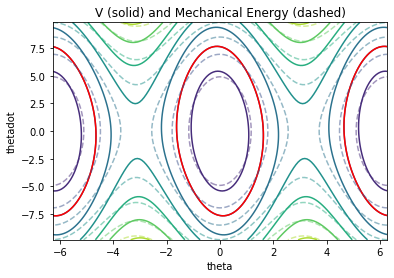

In [87]:
# Plot the results as contour plots.
nq = 151
nqd = 151
q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
qd = np.linspace(-2 * p.mass()*p.gravity()*p.length(), 2 * p.mass()*p.gravity()*p.length(), nqd)
Q, QD = np.meshgrid(q, qd)
Energy = .5 * p.mass() * p.length()**2 * QD**2 + p.mass()*p.gravity()*p.length() * (1 - np.cos(Q))
Vplot = Q.copy()
env = {s: 0., c: 1., theta_dot: 0}
for i in range(nq):
    for j in range(nqd):
        env[s] = np.sin(Q[i, j])
        env[c] = np.cos(Q[i, j])
        env[theta_dot] = QD[i, j]
        Vplot[i, j] = V.Evaluate(env)

# plt.rc("text", usetex=True)
fig, ax = plt.subplots()
ax.contour(Q, QD, Vplot)
ax.contour(Q, QD, Vplot, levels = [3], colors = 'r')
ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")
ax.set_title("V (solid) and Mechanical Energy (dashed)")

In [40]:
G

array([[10.74101105,  2.42596626]])

In [225]:
prog = MathematicalProgram()
s = prog.NewIndeterminates(1, 's')
c = prog.NewIndeterminates(1, 'c')
theta = prog.NewIndeterminates(1, 'theta')

state = np.hstack([s, c, theta])

V, Q = prog.NewSosPolynomial(Variables(state), 2)

display(Markdown("$"+ToLatex(Q)+"$"))

$\begin{bmatrix} S_{0,0} & S_{1,0} & S_{2,0} & S_{3,0} \\ S_{1,0} & S_{1,1} & S_{2,1} & S_{3,1} \\ S_{2,0} & S_{2,1} & S_{2,2} & S_{3,2} \\ S_{3,0} & S_{3,1} & S_{3,2} & S_{3,3} \end{bmatrix}$

In [29]:
display(Markdown("$"+ToLatex(V.ToExpression())+"$"))

AttributeError: 'Add' object has no attribute 'ToExpression'

In [33]:
# explicit linearization
A_explicit = np.array([[0, 1], [p.gravity()/p.length(), -p.damping()/(p.mass()*p.length()*p.length())]])
B_explicit = np.array([[0], [1]])

Q_explicit = np.diag([10, 1])
R_explicit = [1]

K_explicit, S_explicit = LinearQuadraticRegulator(A_explicit, B_explicit, Q_explicit, R_explicit)

In [34]:
X_explicit, L_explicit, G_explicit = control.care(A_explicit, B_explicit, Q_explicit, R_explicit)

In [35]:
K_explicit

array([[39.4932081 ,  8.55245308]])

In [36]:
G_explicit

array([[39.4932081 ,  8.55245308]])

In [37]:
B_explicit.T@X_explicit

array([[39.4932081 ,  8.55245308]])

In [42]:
A_cl_ex = A_explicit - B_explicit@K_explicit
Q_ly_ex = np.eye(2)

In [43]:
P_ex = control.lyap(A_cl_ex.T, Q_ly_ex)

In [44]:
np.linalg.eigvals(P_ex)

array([1.39149567, 0.05818603])

In [52]:
P_ex

array([[1.39102074, 0.0251595 ],
       [0.0251595 , 0.05866096]])

In [53]:
candidate_matrix

array([[1.42110175, 0.02141874],
       [0.02141874, 0.05160587]])